## KMeans Clustering on PCA

[[ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.0772]
 [ 0.      0.      0.     ...  0.      0.     -0.3818]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.3818]
 [ 0.      0.      0.     ...  0.      0.      0.5267]
 [ 0.      0.      0.     ...  0.      0.      0.6697]]


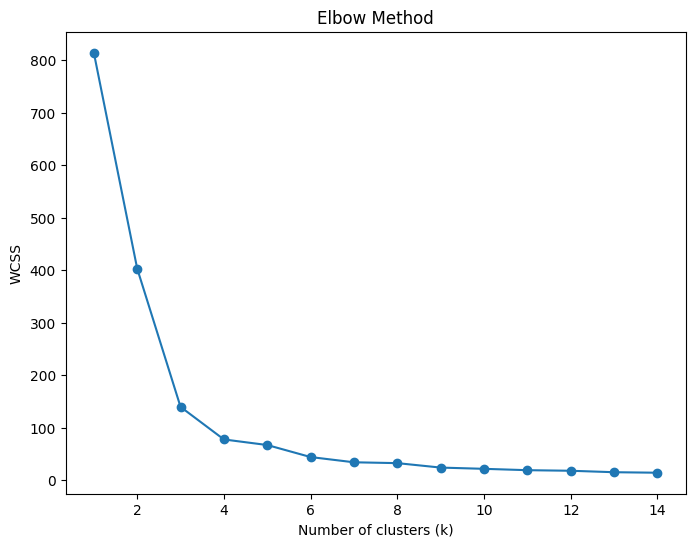

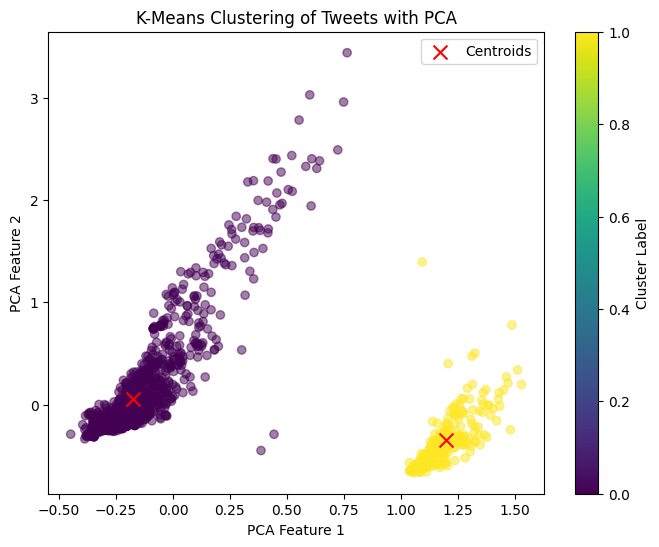

F1 Score: 0.9311377245508982
Text: making lunch | Sentiment: Positive
Text: alexia want money | Sentiment: Positive
Text: dizzyhrvy crap took forever put together going go sleep days | Sentiment: Positive
Text: jnaylor kiwitweets hey jer since start twittering | Sentiment: Positive
Text: trying quot delicious library quot mixed results bar code thought wanted add sport bra instead drill cool app tho | Sentiment: Positive
Text: valenvaldez oh good hear already continue holy week | Sentiment: Positive
Text: got list fellow hotties gon na share one amigo | Sentiment: Positive
Text: jakepaul jamescharles loganpaul shane made series doesnt mean people take seriously https co | Sentiment: Negative
Text: time warsaw beer garden chilling | Sentiment: Positive
Text: hate life lmao hope die soon sumn tired everything | Sentiment: Positive
Text: everything lover survival everything mother survival | Sentiment: Positive
Text: stray cat campus looks like garfield students always feeding fat like | 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA  # Import PCA
from sklearn.cluster import KMeans
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# Load data
data = pd.read_csv('suicide.csv')

# Drop rows with missing 'Tweet'
data.dropna(subset=['Tweet'], inplace=True)

texts = data['Tweet'].tolist()

# Initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Get the VADER compound sentiment score for each tweet
data['sentiment_score'] = data['Tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Feature extraction (Bag of Words)
count_vectorizer = CountVectorizer(max_features=1000, binary=True)
bow_matrix = count_vectorizer.fit_transform(data['Tweet'])

# Convert sparse matrix to dense matrix
bow_matrix_dense = bow_matrix.toarray()

# Standardize the features (important for k-means and PCA)
# scaler = StandardScaler()
# bow_matrix_dense = scaler.fit_transform(bow_matrix_dense)

# Combine Bag of Words matrix with sentiment scores
# Reshape sentiment scores to be added as a feature
sentiment_scores = data['sentiment_score'].values.reshape(-1, 1)
features_combined = np.hstack((bow_matrix_dense, sentiment_scores))

print(features_combined)

# PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)  # Initialize PCA
pca_matrix = pca.fit_transform(bow_matrix_dense)  # Apply PCA transformation

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of square
for i in range(1, 15):  # Test a range of k values
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_matrix)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

optimal_k = 2

# Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster_label'] = kmeans.fit_predict(pca_matrix)

# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot of the clusters
plt.scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=data['cluster_label'], cmap='viridis', alpha=0.5)

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

# Plot details
plt.title('K-Means Clustering of Tweets with PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()

labels = kmeans.labels_
sentiment_labels = ['Positive' if label == 0 else 'Negative' for label in labels]

#---------------------------
tweet_labels = data['Suicide'] 
true_labels = np.where(tweet_labels == 'Potential Suicide Post', 1, 0)

f1 = f1_score(true_labels, labels, average='weighted')
print("F1 Score:", f1)
#------------------------------

# Output sentiment labels for each text
for i, text in enumerate(texts):
    print(f"Text: {text} | Sentiment: {sentiment_labels[i]}")

# Define the filename for the output text file
output_file = "sentiment_labels.txt"

# Open the output file in write mode
with open(output_file, "w") as f:
    # Loop through each text and its corresponding sentiment label
    for text, sentiment_label in zip(texts, sentiment_labels):
        # Write the text and its sentiment label to the file
        print(f"Text: {text} | Sentiment: {sentiment_label}", file=f)

print("Sentiment labels exported to:", output_file)
